In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [3]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour/6
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.hour/6
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = np.log(df['Price'])
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle = True, random_state = 0)
    
    
    return X_train, X_test, y_train, y_test




/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/03/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '27/05/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/04/

      Dep_Time  Arrival_Time  Duration  Total_Stops  Day of Journey  \
508   3.333333      3.000000      1350          1.0              21   
3071  1.000000      2.333333       470          1.0              24   
2036  3.666667      1.666667       695          1.0               3   
49    3.833333      3.166667      1195          2.0              27   
9686  3.666667      0.000000       155          0.0              27   
...        ...           ...       ...          ...             ...   
9225  1.000000      0.666667      1330          1.0               6   
4859  3.666667      3.166667      1275          2.0               6   
3264  1.333333      0.666667      1225          1.0               3   
9845  1.833333      2.000000      1505          1.0              18   
2732  3.333333      3.833333      1630          1.0               5   

      Month of Journey  Meal  Baggage  S_Banglore  S_Chennai  ...  GoAir  \
508                  5   0.0      0.0           0          0  ...      

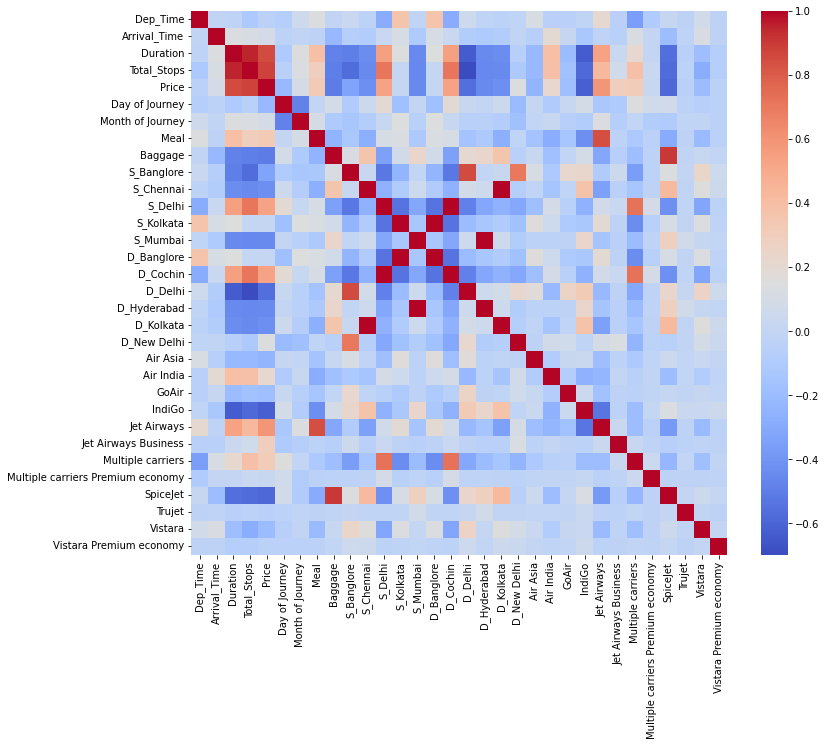

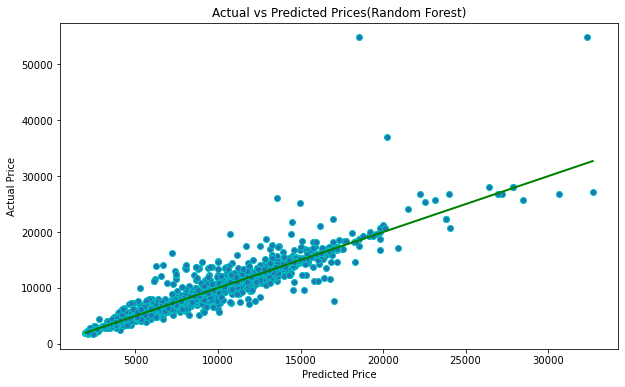

Linear : R2 Score = 0.6176
                   RMSE = 2846
                    MAE = 1776
                   MAPE = 19.19 %



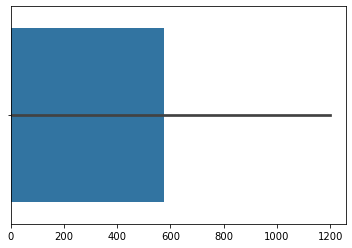

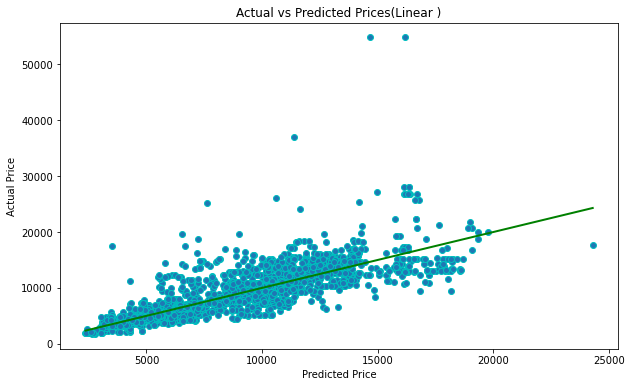

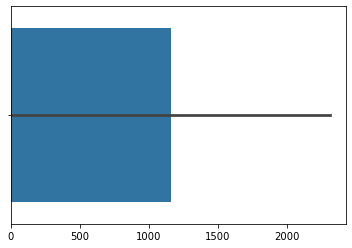

In [4]:
data = pd.read_excel('Data_Train.xlsx')

X_train, X_test, y_train, y_test = preprocess_inputs(data)

print(X_train)

models = {
    "Random Forest" : RandomForestRegressor(),
    "Linear ": LinearRegression() 
}


for name, model in models.items():
    model.fit(X_train, y_train)
    
y_test = np.exp(y_test)

for name, model in models.items():
    y_pred = np.exp(model.predict(X_test))
    
    #displaying errors numerically

    print(name + ": R2 Score = {:.4f}".format(r2_score(y_test, y_pred)))
    print("                   RMSE = {:.0f}".format((mean_squared_error(y_test, y_pred, squared = False))))
    print("                    MAE = {:.0f}".format(mean_absolute_error(y_test, y_pred)))
    print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_test, y_pred) * 100))
    
    #displaying results in a graph
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_test, edgecolor='c')
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], c='g', lw=2)
    plt.title("Actual vs Predicted Prices" + "(" + name +")")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.show()
    
    
    """
    #displaying errors in a graph
    
    R2 = r2_score(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared = False)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)*100
                    
    df_error = pd.DataFrame({name:[R2,RMSE,MAE,MAPE]})
    sns.barplot(data=df_error, x = [R2,RMSE,MAE,MAPE], hue = name)
    
   
    

    
    